<a href="https://colab.research.google.com/github/monimoyd/S8/blob/master/S8_ml_best1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment S8
In this assignment Resnet architecture is used to train CIPHAR10 dataset. Developed APIs so as to load data, train, test and show results.

Following changes are done:
1. Dropout is added to the Base ResNet18 model
2. Added random cropping Image augmentation 
3. Added L2 regularization


In [0]:
%matplotlib inline

## Mount the google drive

In [2]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Copy all the API python files from the google drive to local folder

Follwing python files are imported from google drive. Purpsoe of these files are as below:

model.py - Defines the model class Net
train_test.py- API for training and testing
accuracy_utils - API foro getting test accuracy and per class accuracy
data_loader.py - API for loading train and test data
data_transform.py - API for transforming and normalizing data
plot_metrics.py - API for plotting metrics

In [0]:
!cp '/content/drive/My Drive/eva4_apis/resnet18.py' .
!cp '/content/drive/My Drive/eva4_apis/train_test.py' .
!cp '/content/drive/My Drive/eva4_apis/accuracy_utils.py' .
!cp '/content/drive/My Drive/eva4_apis/data_loader.py' .
!cp '/content/drive/My Drive/eva4_apis/plot_metrics.py' .
!cp '/content/drive/My Drive/eva4_apis/data_transform.py' .

## Import all the libraries

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from resnet18 import ResNet18
from train_test import train, test
from data_transform import get_train_transform, get_test_transform
from data_loader import get_train_loader, get_test_loader, get_classes
from accuracy_utils import get_test_accuracy,get_accuracy_per_class
from plot_metrics import plot_loss_accuracy


Training a Classifier
=====================



Training an image classifier
----------------------------

I have done the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data





 ## 1. Loading and normalizing CIFAR10

 I have used APIs get_train_loader, get_test_loader to load train data and test data respectively. Both the APIs internally uses torchvision. I have used get_transform API to transform tensors in the range [-1,1]



In [5]:
transform_train = get_train_transform()
transform_test = get_test_transform()

trainloader = get_train_loader(128, transform_train)
testloader = get_test_loader(128, transform_test)
classes = get_classes()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualizing some of the images in train dataset



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 bird plane   dog  ship


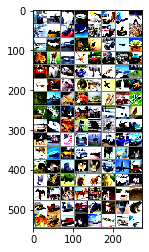

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolution Neural Network

I have defined the basic ResNet18 model and added dropout to it



In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model =  ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
         Dropout2d-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         Dropout2d-8           [-1, 64, 32, 32]               0
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        Dropout2d-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

/content/resnet18.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


## 3. Define a Loss function and optimizer and train the model

I have used Classification Cross-Entropy loss and SGD with learning rate 0.01 with momentum 0.9.

## 4. Train the model

 I have used 30 epochs to train the model

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []



In [10]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

model =  ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 30
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch, train_losses,train_acc )
    test(model, device, testloader, test_losses, test_acc)
    scheduler.step()

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


/content/resnet18.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Loss=6.314135551452637 Batch_id=390 Accuracy=41.31: 100%|██████████| 391/391 [03:15<00:00,  2.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.5755, Accuracy: 4248/10000 (42.48%)

EPOCH: 1


Loss=3.737288236618042 Batch_id=390 Accuracy=47.85: 100%|██████████| 391/391 [03:15<00:00,  2.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.4401, Accuracy: 4662/10000 (46.62%)

EPOCH: 2


Loss=3.3232052326202393 Batch_id=390 Accuracy=50.54: 100%|██████████| 391/391 [03:15<00:00,  2.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.8097, Accuracy: 4090/10000 (40.90%)

EPOCH: 3


Loss=2.9845097064971924 Batch_id=390 Accuracy=52.52: 100%|██████████| 391/391 [03:16<00:00,  2.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.5037, Accuracy: 4755/10000 (47.55%)

EPOCH: 4


Loss=2.944131374359131 Batch_id=390 Accuracy=54.24: 100%|██████████| 391/391 [03:16<00:00,  2.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2624, Accuracy: 5426/10000 (54.26%)

EPOCH: 5


Loss=2.9348692893981934 Batch_id=390 Accuracy=55.80: 100%|██████████| 391/391 [03:16<00:00,  2.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.4421, Accuracy: 4830/10000 (48.30%)

EPOCH: 6


Loss=1.7273719310760498 Batch_id=390 Accuracy=66.28: 100%|██████████| 391/391 [03:16<00:00,  2.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8376, Accuracy: 7082/10000 (70.82%)

EPOCH: 7


Loss=1.9250555038452148 Batch_id=390 Accuracy=68.54: 100%|██████████| 391/391 [03:16<00:00,  2.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8824, Accuracy: 6944/10000 (69.44%)

EPOCH: 8


Loss=1.5370872020721436 Batch_id=390 Accuracy=69.55: 100%|██████████| 391/391 [03:16<00:00,  2.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8735, Accuracy: 6924/10000 (69.24%)

EPOCH: 9


Loss=1.7402743101119995 Batch_id=390 Accuracy=70.75: 100%|██████████| 391/391 [03:16<00:00,  2.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7753, Accuracy: 7297/10000 (72.97%)

EPOCH: 10


Loss=1.8002607822418213 Batch_id=390 Accuracy=71.17: 100%|██████████| 391/391 [03:16<00:00,  2.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7797, Accuracy: 7301/10000 (73.01%)

EPOCH: 11


Loss=1.7638154029846191 Batch_id=390 Accuracy=72.04: 100%|██████████| 391/391 [03:16<00:00,  2.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7805, Accuracy: 7334/10000 (73.34%)

EPOCH: 12


Loss=1.3410749435424805 Batch_id=390 Accuracy=78.11: 100%|██████████| 391/391 [03:16<00:00,  2.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5546, Accuracy: 8099/10000 (80.99%)

EPOCH: 13


Loss=1.2048401832580566 Batch_id=390 Accuracy=79.92: 100%|██████████| 391/391 [03:16<00:00,  2.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5342, Accuracy: 8181/10000 (81.81%)

EPOCH: 14


Loss=1.0997071266174316 Batch_id=390 Accuracy=80.37: 100%|██████████| 391/391 [03:16<00:00,  2.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5164, Accuracy: 8235/10000 (82.35%)

EPOCH: 15


Loss=1.2152645587921143 Batch_id=390 Accuracy=80.92: 100%|██████████| 391/391 [03:15<00:00,  2.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5135, Accuracy: 8279/10000 (82.79%)

EPOCH: 16


Loss=1.2264512777328491 Batch_id=390 Accuracy=81.49: 100%|██████████| 391/391 [03:15<00:00,  2.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5035, Accuracy: 8303/10000 (83.03%)

EPOCH: 17


Loss=1.1242256164550781 Batch_id=390 Accuracy=81.71: 100%|██████████| 391/391 [03:15<00:00,  2.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4997, Accuracy: 8313/10000 (83.13%)

EPOCH: 18


Loss=1.0195937156677246 Batch_id=390 Accuracy=83.99: 100%|██████████| 391/391 [03:15<00:00,  2.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4636, Accuracy: 8462/10000 (84.62%)

EPOCH: 19


Loss=1.1037931442260742 Batch_id=390 Accuracy=84.65: 100%|██████████| 391/391 [03:14<00:00,  2.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4588, Accuracy: 8474/10000 (84.74%)

EPOCH: 20


Loss=0.965283989906311 Batch_id=390 Accuracy=84.84: 100%|██████████| 391/391 [03:16<00:00,  2.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4579, Accuracy: 8465/10000 (84.65%)

EPOCH: 21


Loss=1.0757477283477783 Batch_id=390 Accuracy=85.29: 100%|██████████| 391/391 [03:16<00:00,  2.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4544, Accuracy: 8479/10000 (84.79%)

EPOCH: 22


Loss=1.0101183652877808 Batch_id=390 Accuracy=85.36: 100%|██████████| 391/391 [03:15<00:00,  2.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4539, Accuracy: 8483/10000 (84.83%)

EPOCH: 23


Loss=0.859192967414856 Batch_id=390 Accuracy=85.52: 100%|██████████| 391/391 [03:15<00:00,  2.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4483, Accuracy: 8507/10000 (85.07%)

EPOCH: 24


Loss=0.9554926156997681 Batch_id=390 Accuracy=86.07: 100%|██████████| 391/391 [03:15<00:00,  2.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4445, Accuracy: 8531/10000 (85.31%)

EPOCH: 25


Loss=0.7960834503173828 Batch_id=390 Accuracy=86.17: 100%|██████████| 391/391 [03:14<00:00,  2.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4459, Accuracy: 8525/10000 (85.25%)

EPOCH: 26


Loss=0.9614863395690918 Batch_id=390 Accuracy=86.38: 100%|██████████| 391/391 [03:15<00:00,  2.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4454, Accuracy: 8528/10000 (85.28%)

EPOCH: 27


Loss=0.8264625072479248 Batch_id=390 Accuracy=86.19: 100%|██████████| 391/391 [03:15<00:00,  2.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4464, Accuracy: 8514/10000 (85.14%)

EPOCH: 28


Loss=1.0380147695541382 Batch_id=390 Accuracy=86.25: 100%|██████████| 391/391 [03:15<00:00,  2.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4452, Accuracy: 8537/10000 (85.37%)

EPOCH: 29


Loss=1.1167728900909424 Batch_id=390 Accuracy=86.41: 100%|██████████| 391/391 [03:15<00:00,  2.48it/s]



Test set: Average loss: 0.4458, Accuracy: 8546/10000 (85.46%)



## 5. Test the network on the test data 


In this step
- A few actual images are shown with label.
- Next print the test accuracy using API get_test_accuracy
- Next diplay class level accuracy using API get_accuracy_per_class which will give idea about which all classes prediction was good and which all classes prediction was not that good



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


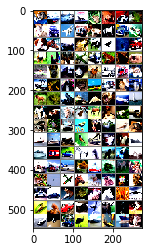

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [12]:
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images) 

/content/resnet18.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [14]:
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    get_test_accuracy(model, testloader, device)))

/content/resnet18.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of the network on the 10000 test images: 85.46 %


The accuracy 84.46 is far better than chance, which is 10% accuracy (randomly picking a class out of 10 classes).
Seems like the network learnt good.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [15]:
class_correct,class_total = get_accuracy_per_class(model, testloader, device)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/content/resnet18.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of plane : 86 %
Accuracy of   car : 96 %
Accuracy of  bird : 72 %
Accuracy of   cat : 52 %
Accuracy of  deer : 88 %
Accuracy of   dog : 78 %
Accuracy of  frog : 86 %
Accuracy of horse : 92 %
Accuracy of  ship : 93 %
Accuracy of truck : 92 %


## Plot the performance metrics

In this step, the following metrics are plotted

i. Training Loss
ii. Training Accuracy
iii. Test Loss
iv. Test Accuracy

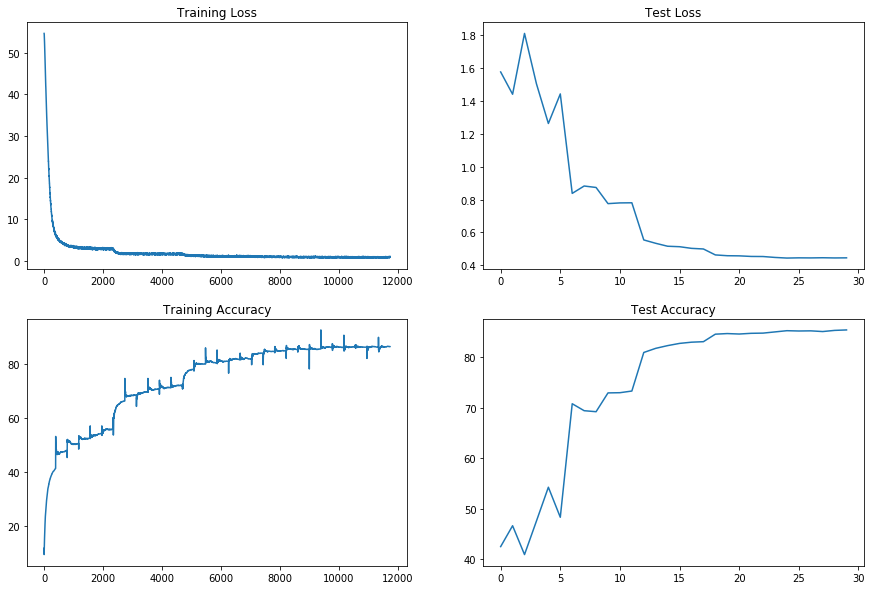

In [16]:
plot_loss_accuracy(train_losses, train_acc, test_losses, test_acc)